# Example Notebook for none-regressive TCN-TCN model

In [ ]:
from tcn_sequence_models.data_processing.preprocessor import Preprocessor
from tcn_sequence_models.models import TCN_Seq2Seq
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import os
from tcn_sequence_models.utils.scaling import inverse_scale_sequences
import numpy as np

In [2]:
#set config_path to a path on your system. There, the model and preprocessor configs
# will be saved to.
config_path = "./config_TCN_TCN_none_regressive"
os.makedirs(name=config_path, exist_ok=True)

## Load and process data

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00616/Tetuan%20City%20power%20consumption.csv"
df = pd.read_csv(url)

In [4]:
time_col = 'DateTime'
df[time_col]= pd.to_datetime(df[time_col])

In [5]:
# Define features to use
features_input_encoder = [
    "Temperature",
    "Humidity",
    "Wind Speed",
    "general diffuse flows",
    "diffuse flows"
]

features_input_decoder = [
]

feature_target = "Zone 1 Power Consumption"

In [6]:
# Add temporal encodings. Possible are: 'seasons', 'months', 'weekdays' and 'hours'
temporal_encoding_modes = ["weekdays", "hours"]

In [7]:
split_ratio = 0.7
input_seq_len = 100
output_seq_len = 50
# Here use the none-regressive model. If you want to use the auto-regressive model
# with teacher-forcing, set it to True
autoregressive = False

In [8]:
preprocessor = Preprocessor(df)

In [9]:
# split_date = datetime.date(2019, 1, 1)
preprocessor.process(
    features_input_encoder,
    features_input_decoder,
    feature_target,
    input_seq_len,
    output_seq_len,
    model_type="tcn_tcn",
    time_col=time_col,
    split_ratio = split_ratio,
    split_date = None,
    temporal_encoding_modes=temporal_encoding_modes,
    autoregressive=autoregressive,
    )

In [10]:
X_train, y_train, X_val, y_val = preprocessor.train_test_split(split_ratio)

## Create model and fit it

In [11]:
from tensorflow.keras.optimizers import Adam

model = TCN_Seq2Seq()

model.build(
    num_layers_tcn = None,
    num_filters = 6,
    kernel_size = 9,
    dilation_base = 2,
    dropout_rate = 0.2,
    key_size = 6,
    value_size = 6,
    num_attention_heads = 2,
    neurons_output = [16],
    activation = "relu",
    kernel_initializer = "he_normal",
    batch_norm_tcn = True,
    layer_norm_tcn = False,
    autoregressive=autoregressive,
    padding_encoder='same',
    padding_decoder='same')
model.compile(optimizer=Adam(lr=0.03, decay=1e-3))


2022-07-04 19:05:59.560257: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-07-04 19:05:59.624297: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.7715GHz coreCount: 15 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 238.66GiB/s
2022-07-04 19:05:59.624338: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-07-04 19:05:59.627214: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-07-04 19:05:59.627274: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-07-04 19:05:59.628796: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

In [12]:
cb_early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
model.fit(X_train,
          y_train,
          (X_val, y_val),
          epochs=10,
          batch_size=64,
          callbacks = cb_early_stopping
          )

2022-07-04 19:06:00.338131: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-04 19:06:00.338610: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3193490000 Hz


Epoch 1/10
training call


2022-07-04 19:06:08.639177: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-07-04 19:06:08.996117: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2022-07-04 19:06:09.350068: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-04 19:06:09.350128: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-07-04 19:06:09.350627: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-04 19:06:09.350738: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-07-04 19:06:09.360429: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully ope

571/571 [==============================] - 33s 41ms/step - loss: 0.6947 - val_loss: 0.4210
Epoch 2/10
571/571 [==============================] - 22s 39ms/step - loss: 0.1362 - val_loss: 0.2178
Epoch 3/10
571/571 [==============================] - 22s 39ms/step - loss: 0.1016 - val_loss: 0.1836
Epoch 4/10
571/571 [==============================] - 22s 39ms/step - loss: 0.0859 - val_loss: 0.2202
Epoch 5/10
571/571 [==============================] - 22s 39ms/step - loss: 0.0770 - val_loss: 0.1957
Epoch 6/10
571/571 [==============================] - 23s 39ms/step - loss: 0.0708 - val_loss: 0.2010


## Make predictions

In [17]:
y_pred = model.predict(X_val)

In [14]:
y_pred = y_pred.squeeze(axis=-1)

In [35]:
y_pred_unscaled = inverse_scale_sequences(y_pred, preprocessor.scaler_y)
y_val_unscaled = inverse_scale_sequences(np.expand_dims(y_val, axis=-1),
                                                        preprocessor.scaler_y)

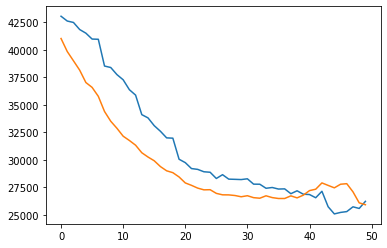

In [36]:
plt.plot(y_pred_unscaled[3000])
plt.plot(y_val_unscaled[3000])
plt.show()

## Save the preprocessor and the model

In [37]:
preprocessor.save_preprocessor_config(save_path=config_path)

In [38]:
model.save_model(config_path)

## Load the saved preprocessor and model

In [39]:
preprocessor_loaded = Preprocessor(df)
preprocessor_loaded.load_preprocessor_config(load_path=config_path)

In [40]:
# Load with the intention to only use the model for inference. If the model shall be
# trained, use process_from_config_training() and the get the training data with the
# train_test_split() method.
preprocessor_loaded.process_from_config_inference()

In [41]:
model_loaded = TCN_Seq2Seq()

In [44]:
model_loaded.load_model(config_path, preprocessor_loaded.X, is_training_data=False)
# If you use the autoregressive model:
# model_loaded.load_model(config_path, X_init[:3],
# is_training_data=True)

1
2
3
inference call
4
5


In [45]:
y_pred = model_loaded.predict(preprocessor_loaded.X)

inference call


In [46]:
y_pred_unscaled = inverse_scale_sequences(y_pred, preprocessor_loaded.scaler_y)
y_true_unscaled = inverse_scale_sequences(np.expand_dims(preprocessor.y, axis=-1),
                                                        preprocessor_loaded.scaler_y)

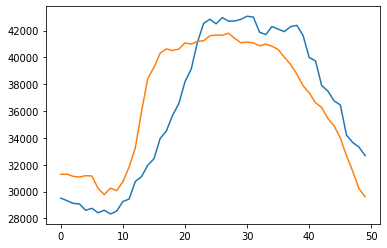

In [48]:
plt.plot(y_pred_unscaled[1000])
plt.plot(y_true_unscaled[1000])
plt.show()

## Run bayessian optimizer to find the optimal hyperparameters

In [53]:
model.parameter_search(
        X_train,
        y_train,
        X_val,
        y_val,
        batch_size = 64,
        results_path = "./search_1",
        patience=3,
        loss = "mse",
        max_trials = 2,
        executions_per_trial = 1,
        num_filters = [4, 6, 8],
        neurons_output = [16],
        kernel_size = [5, 9, 13, 17],
        dilation_base = [2],
        dropout_rate = [0.1, 0.2, 0.3],
        key_value_size = [4, 6, 8],
        num_attention_heads = [1, 2],
        activation = ["elu"],
        kernel_initializer = ["he_normal"],
        batch_norm_tcn = [False],
        layer_norm_tcn = [True],
        padding_encoder = ['same', 'causal'],
        padding_decoder = ['same', 'causal']
    )


Trial 2 Complete [00h 02m 20s]
val_loss: 0.18431484699249268

Best val_loss So Far: 0.18036608397960663
Total elapsed time: 00h 04m 41s
INFO:tensorflow:Oracle triggered exit
